# Fictitous Play

This note demonstrates how to use `fictplay` Julia functions.

In [1]:
include("fictplay.jl")
using Distributions
using StatsBase
using Plots
import PyPlot
using StatsPlots

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


Fictitious play is first introduced as a learning model by Brown(1951) and Robinson(1951). In fictitious play model, players choose their strategies to maximize their payoffs with the beliefs such that their opponents will play each strategy with the probability equal to its historical frequency. In this note, we focus on two-player game.

## Model

- $i=1,2$ : players
- $S_i$ : the finite set of pure strategies
    - $S = S_1 \times S_2$ : the set of pure strategy profile
    - $s_i \in S_i$ : one of the $i$'s pure strategy
- $\Sigma_i$ : the set of mixed strategies
    - $\Sigma = \Sigma_1 \times \Sigma_2$ : the set of mixed strategy profile
    - $\sigma_i \in \Sigma_i$ : one of the $i$'s mixed strategy.
- $u_i(s_i, \sigma_{-i})$ : $i$'s expected utility when he chooses pure strategy $s_i$ and his opponent plays according to $\sigma_{-i}$ 

After each round of play, players observe the actual actions choosen by opponents, and they choose strategies in the next round given histories of opponents actions. When a player choose a mixed strategy, its mixing is not observed, that is, histories of play consist of pure-strategy profiles.

- $t = 1, 2, \cdots$: dates
- $s^{\tau} \in S$ : strategy profile at date $\tau$
- $\zeta^t = (s^1, \cdots, s^{t-1})$ : history of play up to $t$
    - $\zeta^1$ indicates null history
- $\mathcal{Z}^t$ : the set of all histories of play up to $t$
    - by construction, $\mathcal{Z}^1$ is the singleton set consisting of the null history
    - $\mathcal{Z}$ : the set of all possible infinite histories
- $\kappa(\zeta^t)(s_i)$ : the number of times that $i$ played $s_i$ in the $t-1$ observations that comprise $\zeta^t$
    - player $i$ has an exogenous initial weight function $\kappa_i(\zeta^1) : S_{-i} \rightarrow \mathcal{R}_+$

Weight function is updated by adding 1 to the weight of each opponent strategy each time it is played so that:

\begin{equation}
\kappa_i(\zeta^t)(s_{-i}) = \kappa_i(\zeta^{t-1})(s_{-i}) + \left\{ \begin{array}{ll}
    1 & (s_{-i}^{t-1} = s_{-i}) \\
    0 & (s_{-i}^{t-1} \neq s_{-i})
  \end{array} \right.
\end{equation}

Each player assesses concerning the behavior of his opponents at each date and contingent on history

- $\mu_i^t : \mathcal{Z}^t \rightarrow \Sigma_{-i}$ : $i$'s assessment over the possible pure-strategy profiles that hisopponents will choose at date $t$

Then, $\mu_i$ is given by normalizing the $\kappa_i$, that is,

\begin{equation}
\mu_i^t (\zeta^t)(s_{-i}) = \frac{\kappa_i (\zeta^t)(s_{-i})}{\sum_{\tilde{s}_{-i} \in S_{-i}}\kappa_i (\zeta^t)(\tilde{s}_{-i})}
\end{equation}

Each player takes best response, which is a maximizer of 

\begin{equation}
\sum_{s_{-i} \in S_{-i}} u_i(\sigma_i, s_{-i}) \mu_i^t (\zeta^t)(s_{-i})
\end{equation}

over all $\sigma_i \in \Sigma_i$

It is well known that if fictitious play converges to some distribution, those possibilities correspond to Nash equilibrium. However, fictitious play does not always converge. It converges for a two-player game when, for example

- Both players have finite strategies and the game is a zero-sum game
- The game is a potential game
- The game is solvable by IESDS

## Fictitious Play

Let's consider the FictitiousPlay model with the following **matching pennies** payoff matrix

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 1, -1          |    -1, 1   
 $B$           | -1, 1          |   1, -1    

In [2]:
matching_pennies_bimatrix = Array{Float64}(undef, 2, 2, 2)
matching_pennies_bimatrix[:, 1, 1] = [1, -1]
matching_pennies_bimatrix[:, 1, 2] = [-1, 1]
matching_pennies_bimatrix[:, 2, 1] = [-1, 1]
matching_pennies_bimatrix[:, 2, 2] = [1, -1]
g = NormalFormGame(matching_pennies_bimatrix)

2×2 NormalFormGame{2,Float64}

Create a `FictitiousPlay` type with this `NormalFormGame` instance

In [3]:
mp = FictitiousPlay(g)

FictitiousPlay{2,Float64,DecreasingGain}((2×2 Player{2,Float64}:
  1.0  -1.0
 -1.0   1.0, 2×2 Player{2,Float64}:
 -1.0   1.0
  1.0  -1.0), (2, 2), DecreasingGain())

### `play`

play method enables players to take their actions given opponents' normalized action history, and returns the new normalized actions history after taking best responses. You can decide the initial action.

In [4]:
play(mp,(1,1))

([1.0, 0.0], [0.5, 0.5])

You can repeat this procedure several times by keyword argument num_iter as input.

In [5]:
play(mp, (1,1), num_reps=100)

([0.455446, 0.544554], [0.524752, 0.475248])

If you don't designate initial actions, they are choosed randomly.

In [6]:
play(mp)

([0.58471, 0.41529], [0.934684, 0.0653162])

### `time_series`

`time_series` method returns the time series of normalized action history.

In [7]:
time_series(mp, 10, (1,1))

([1.0 1.0 … 0.333333 0.3; 0.0 0.0 … 0.666667 0.7], [1.0 0.5 … 0.333333 0.4; 0.0 0.5 … 0.666667 0.6])

Similary, you can omit initial actions and they choosed randomly.

In [8]:
time_series(mp, 10)

([0.959243 0.479621 … 0.662138 0.695924; 0.040757 0.520379 … 0.337862 0.304076], [0.324131 0.162065 … 0.59157 0.532413; 0.675869 0.837935 … 0.40843 0.467587])

## Simulations

### Two-actions game

Let's simulate fictitious play model with matching pennies game defined above.

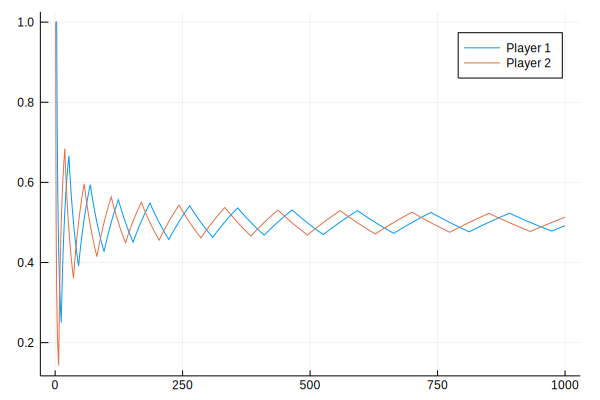

In [9]:
ts_length = 1000
init_actions = (1,1)
series = time_series(mp, ts_length, init_actions)
x = [series[1][1,:], series[2][1,:]]
labels = ["Player 1", "Player 2"]
plot(x, label=labels)

Horizontal and vertical axis correspond to the period and the player's belief for his opponent's first action. Blue(Orange) line represents first(second) player's belief. As you can see, both players' assesements converge to $(0.5, 0.5)$, which is the maixed strategy Nash Equilibrium of this game. This result is consistent with manu papers.

### Three-actions game

Consider the fictitious play model of shapley game whose payoff matrix is

1$\backslash$2 | $A$           | $B$    |$C$
 ------------- |---------------| ---------|-----------
 $A$           | 0, 0          |    1, 0   |   0,1
 $B$           | 0, 1          |   0, 0   |    1,0
 $C$           |1,0           | 0,1      | 0,0

In [10]:
shapley_game = Array{Int}(undef, 3, 3, 2)
shapley_game[:, 1, 1] = [0, 0, 1]
shapley_game[:, 2, 1] = [1, 0, 0]
shapley_game[:, 3, 1] = [0, 1, 0]
shapley_game[:, 1, 2] = [0, 1, 0]
shapley_game[:, 2, 2] = [0, 0, 1]
shapley_game[:, 3, 2] = [1, 0, 0]
g = NormalFormGame(shapley_game)

3×3 NormalFormGame{2,Int64}

Create a `FictitiousPlay` instance

In [11]:
sg = FictitiousPlay(g)

FictitiousPlay{2,Int64,DecreasingGain}((3×3 Player{2,Int64}:
 0  1  0
 0  0  1
 1  0  0, 3×3 Player{2,Int64}:
 0  1  0
 0  0  1
 1  0  0), (3, 3), DecreasingGain())

Let's simulate the fictitious play model of this game.

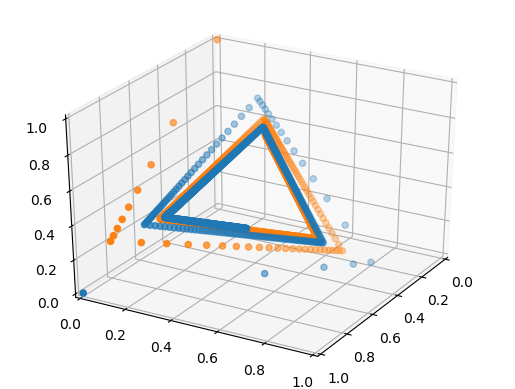

In [12]:
ts_length = 1000
init_actions = (1,3)
series = time_series(sg, ts_length, init_actions)
ax = PyPlot.subplot(111, projection="3d")
colors = ["C0", "C1"]
for i in 1:2
    ax.scatter(series[i][1, :], series[i][2, :], series[i][3, :], c=colors[i])
end
for prop in [:set_xlim, :set_ylim, :set_zlim]
    getproperty(ax, prop)((0, 1))
end
ax.view_init(ax.elev, ax.azim+90)

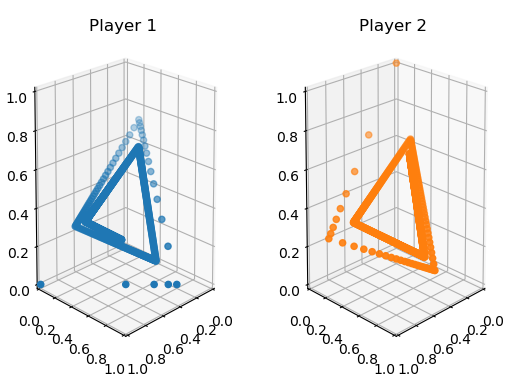

In [13]:
fig = PyPlot.figure()
for i in 1:2
    ax = fig.add_subplot(1, 2, i, projection="3d")
    ax.scatter(series[i][1, :], series[i][2, :], series[i][3, :], c=colors[i])
    for prop in [:set_xlim, :set_ylim, :set_zlim]
        getproperty(ax, prop)((0, 1))
    end
    ax.view_init(ax.elev-15, ax.azim+105)
    ax.set_title("Player $i")
end

X-axis(bottom right), y-axis(bottom left) and z-axis(vertical axis) correspond to player's belief for opponent's first, second third action respectively. Blue(Red) points represent first(second) player's belief at each period for opponent's action.

Shapley(1964) showed that in the normal fictitious play (not weighted fictitious play) if $(A, B)$ is choosen in the first period, then players' beliefs do not converge. In addition, the fictitious play follows the cycle $(A, B) \rightarrow (A, C) \rightarrow (B, C) \rightarrow (B,A) \rightarrow (C,A) \rightarrow (C, B) \rightarrow (A, B) \rightarrow \cdots$

---

# Stochastic Fictitous Play

Stochastic fictitious play is first introduced by Fundenberg and Kreps(1993). In this model, each player's payoff is perturbed in each period by a random shock.

## Model

Almost all of the settings are same as original fictitious play model except for paerturbated payoff. Player's payoff at period $t$ is given by 

\begin{equation}
u_i^t (s_i^t, s_{-i}^t) + \eta_i(s_i^t)
\end{equation}

The random payoff shock $\eta_i$ is observable for each $i$, but player $i$ cannot observe opponents' payoff shock and its history. Let $\rho_i$ denote the probability distribution of each $\eta_i$ and $E_i$ denote the support of $\rho_i$.

In each period, players choose their strategy after observing payoff shock, so in the stage game strategy for each player is a mapping form $E_i$ to $S_i$. Note that we do not need to consider mixed startegies in this augmented game.

Fundenberg and Kreps(1993) showed that in any $2 \times 2$ game that has a unique completely mixed Nash equilibrium, stochastic fictitious play converges with pobability 1 with some assumptions.

In adddition, Hofbauer and Sandholm (2002) showed that in (i) two-player symmetric game with an interior ESS (ii) two-player zero sum game, and some game classes, stochastic fictitious play converges.

## Stochastic Fictitious Play

`fictplay` module also provides `StochasticFictitiousPlay` type. Each payoff shock follows same distribution, **gumbel distribution** or **standard normal distribution**, that is, $\eta_i(\cdot) \sim Gumbel(\mu, \beta)$ or $\eta_i(\cdot) \sim N(0, 1)$ for all $i$. $\eta_i(s_i)$ ($i = 1,2$, $s_i \in S_i$) are independent and identically distributed.

Similar to `FictitiousPlay` type, we have the functions `get_iterate_result` and `get_time_series`.

## Simulations

Let's simulate stochastic fictitious play model. We set the distribution of payoff shock to Type 1 extreme distribution in the next two examples.

### Two-action Game

First, we consider matching penny game defined above. You have to designate the distiribution of payoff pertubation, which must be `distribution` type.

In [14]:
# Set the distribution of shocks to standard normal distribution
normal = Normal()

Normal{Float64}(μ=0.0, σ=1.0)

In [15]:
g = NormalFormGame(matching_pennies_bimatrix)
smp = StochasticFictitiousPlay(g, normal)

StochasticFictitiousPlay{2,Float64,Normal{Float64},DecreasingGain}((2×2 Player{2,Float64}:
  1.0  -1.0
 -1.0   1.0, 2×2 Player{2,Float64}:
 -1.0   1.0
  1.0  -1.0), (2, 2), Normal{Float64}(μ=0.0, σ=1.0), DecreasingGain())

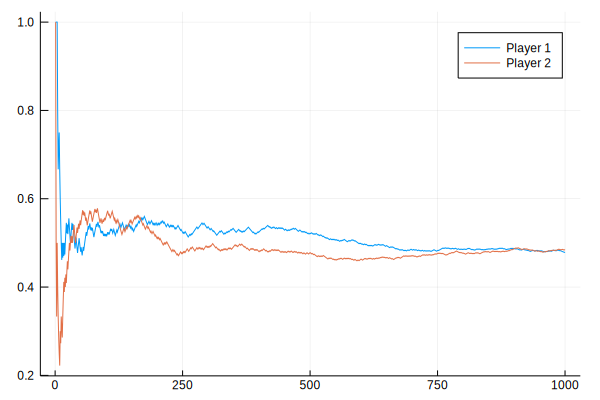

In [16]:
ts_length = 1000
init_actions = (1,1)
series = time_series(smp,ts_length,init_actions)
x = [series[1][1,:], series[2][1,:]]
labels = ["Player 1", "Player 2"]
plot(x, label=labels)

As shown in the above graph, both players' beliefs converge to  $0.5$ , which is the mixed-strategy Nash equilibrium of the original game. This result is not different from that of the standard fictitous play model, we simulate before.

### Three-action Game

Next, we consider shapley game discussed above.

In [17]:
normal = Normal()

Normal{Float64}(μ=0.0, σ=1.0)

In [18]:
g = NormalFormGame(shapley_game)
ssg = StochasticFictitiousPlay(g, normal)

StochasticFictitiousPlay{2,Int64,Normal{Float64},DecreasingGain}((3×3 Player{2,Int64}:
 0  1  0
 0  0  1
 1  0  0, 3×3 Player{2,Int64}:
 0  1  0
 0  0  1
 1  0  0), (3, 3), Normal{Float64}(μ=0.0, σ=1.0), DecreasingGain())

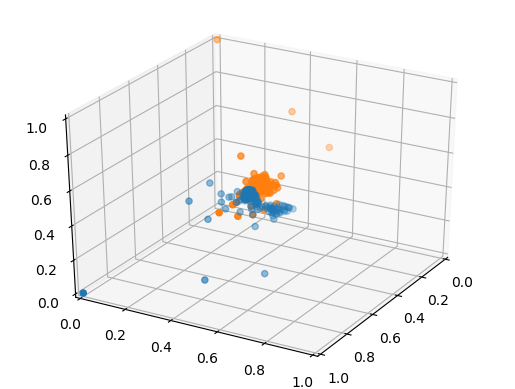

In [19]:
ts_length=1000
init_actions=(1,3)
series = time_series(ssg, ts_length, init_actions)
ax = PyPlot.subplot(111, projection="3d")
colors = ["C0", "C1"]
for i in 1:2
    ax.scatter(series[i][1, :], series[i][2, :], series[i][3, :], c=colors[i])
end
for prop in [:set_xlim, :set_ylim, :set_zlim]
    getproperty(ax, prop)((0, 1))
end
ax.view_init(ax.elev, ax.azim+90)

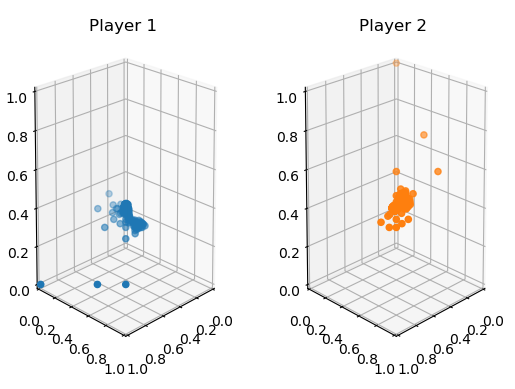

In [20]:
fig = PyPlot.figure()
for i in 1:2
    ax = fig.add_subplot(1, 2, i, projection="3d")
    ax.scatter(series[i][1, :], series[i][2, :], series[i][3, :], c=colors[i])
    for prop in [:set_xlim, :set_ylim, :set_zlim]
        getproperty(ax, prop)((0, 1))
    end
    ax.view_init(ax.elev-15, ax.azim+105)
    ax.set_title("Player $i")
end

Stochastic fictitious play converges to $(1/3, 1/3, 1/3)$ which is a mixed Nash equilibrium of this game. This  is consistent with the result of Hofbauer and Sandholm (2002) since $(1/3, 1/3, 1/3)$ is an interior ESS and a unique equilibrium. This result is quite different from the result of standard fictitious play model where shapley game does not converge.

## Stochastic Fictitious Play with constant gain

Many literatures say fictitous play and stochastic fictitious play converge to some equilibria, but they doesn't say fictitous play converges to which equilibrium in most cases. Williams(2018) answers this question under stochastic fictitious play with constant gain. He shows that risk dominant equilibrium is stable.

Let's consider the model with the following **Coordination Game** payoff matrix

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 4, 4          |    0, 3   
 $B$           | 3, 0          |   2, 2    

In [21]:
coordination_game_matrix = [4 0; 3 2]
g = NormalFormGame(coordination_game_matrix)

2×2 NormalFormGame{2,Int64}

In [22]:
normal = Normal(0, 0.33)
scg = StochasticFictitiousPlay(g, normal, ConstantGain(0.1))

StochasticFictitiousPlay{2,Int64,Normal{Float64},ConstantGain{Float64}}((2×2 Player{2,Int64}:
 4  0
 3  2, 2×2 Player{2,Int64}:
 4  0
 3  2), (2, 2), Normal{Float64}(μ=0.0, σ=0.33), ConstantGain{Float64}(0.1))

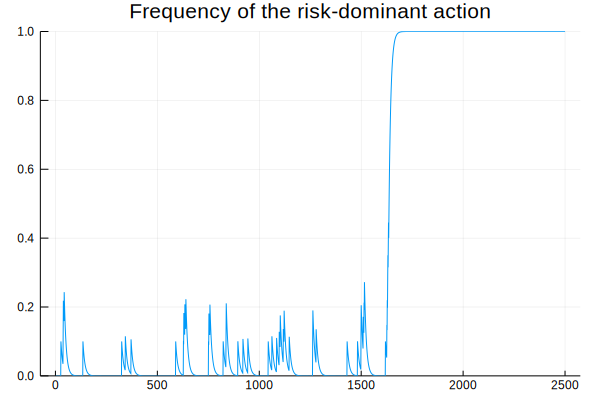

In [24]:
ts_length = 2500
init_actions = (1,1)
series = time_series(scg,ts_length,init_actions)
plot(series[1][2,:], ylims=(0, 1), legend=false, title="Frequency of the risk-dominant action")

---

# N-player Game

So far, we consider two-player games with two or three actions for each player. We can extend the fictitous play model to more general games where there are n players. Monderer and Shapley(1996) shows that in the game with identical payoff functions, players' beliefs converge.

Note that fictitious player game with n players is different from the literature in the sense that players' beliefs are updated simply. That is, player i 's belief for player j depends only on past player j 's actions, not on other players' actions.

## Simulation

We simulate n-player fictitious play with **Cournot Game**. First, we define `cournot` function which returns `NormalFormGame` instance representing Cournot Game.

In [25]:
"""
    function cournot(a::Real, c::Real, ::Val{N}, q_grid::Vector{T})

# Arguments

- `a::Real` : Intercept of the demand curve
- `c::Real` : Common constant marginal cost
- `::Val{N}` : Number of players
- `q_grid::Vector{T}` : Vector containing the set of possible quantities

# Return

- `::NormalFormGame` : `NormalFormGame` instance which represents Cournot game

"""
function cournot(a::Real, c::Real, ::Val{N}, q_grid::Vector{T}) where {N,T<:Real}
    nums_actions = ntuple(x->length(q_grid), Val(N))
    S = promote_type(typeof(a), typeof(c), T)
    payoff_array= Array{S}(undef, nums_actions)
    x = [q_grid for i in 1:N]
    Cartesian = collect(Iterators.product(x...))
    for I in CartesianIndices(size(Cartesian))
        payoff_array[I] = (a - c - sum(Cartesian[I])) * Cartesian[I][1]
    end
    players = ntuple(x->Player(payoff_array), Val(N))
    return NormalFormGame(players)
end

cournot

In [26]:
a, c = 80, 20
N = 3
q_grid = [10, 15]  # [1/3 of Monopoly quantity, Nash equilibrium quantity]

g_Cou = cournot(a, c, Val(N), q_grid)

2×2×2 NormalFormGame{3,Int64}

Payoff matrix is seemes to be:

$A$ | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 300, 300, 300          |   250, 250, 375   
 $B$           | 250, 375, 250          |   200, 300, 300  
 
 $B$ | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 375, 250, 250          |   300, 200, 300   
 $B$           | 300, 300, 200          |   225, 225, 225  

As you know, ($B$, $B$, $B$) is a Nash equilibrium.

In [27]:
fp_Cou = FictitiousPlay(g_Cou)
ts_length = 50
init_actions = (1,1,1)
series = time_series(fp_Cou,ts_length,init_actions)

([1.0 0.5 … 0.0204082 0.02; 0.0 0.5 … 0.979592 0.98], [1.0 0.5 … 0.0204082 0.02; 0.0 0.5 … 0.979592 0.98], [1.0 0.5 … 0.0204082 0.02; 0.0 0.5 … 0.979592 0.98])

The graph below describes the fraction of taking action $A$.

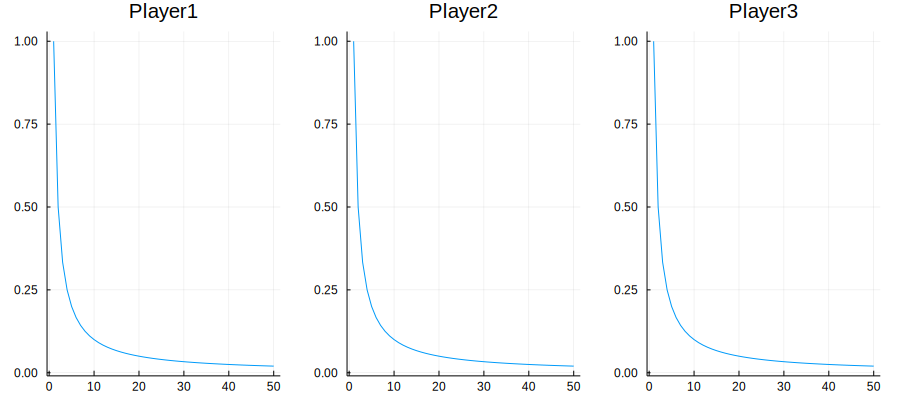

In [28]:
p1 = plot(series[1][1,:], legend=false, title="Player1")
p2 = plot(series[2][1,:], legend=false, title="Player2")
p3 = plot(series[3][1,:], legend=false, title="Player3")
plot(p1,p2,p3, layout=(1,3), size=(900,400))

As you can see, all players take action $B$, which is a stretegy in Nash equilibrium.

---

# Reference

- Brown, G. W. 1951. Iterative solutions of games by fictitious play. In Activity Analysis of Production and Allocation, ed. by T.C.Koopmans. New York: Wiley.
- Robinson, J. 1951. An iterative method of solving a game. Annals of Mathmatics 54: 296-301.
- Shapley, L. 1964. Some topics in two-person games. In Advances in Game Theory, ed. by M. Drescher, L. S. Shapley, and A. W. Tucker. Princeton: Princeton University Press.
- Fudenberg, D., and D. Kreps. 1993. Learning mixed equilibria. Games and Economic Behavior 5: 320-67.
- Monderer, D., and Shapley, L. 1996. Fictitious Play Property for Games with Identical Interests. Journal of Economic Theory 68, 258-265
- Fudenberg, D., and D.K. Levine. 1998. The Theory of Learning in Games Cambridge: MIT Press.
- Hofbauer, J., and W. H. Sandholm. 2002. On the Global Convergence of Stochastic Fictitious Play. Econometrica Vol.70, No. 6: 2265-2294